Using device: cpu
Loading Fashion-MNIST dataset...
Training samples: 60000
Test samples: 10000

Model Architecture:
AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(
      (lrn): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(
      (lrn): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    )
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1),

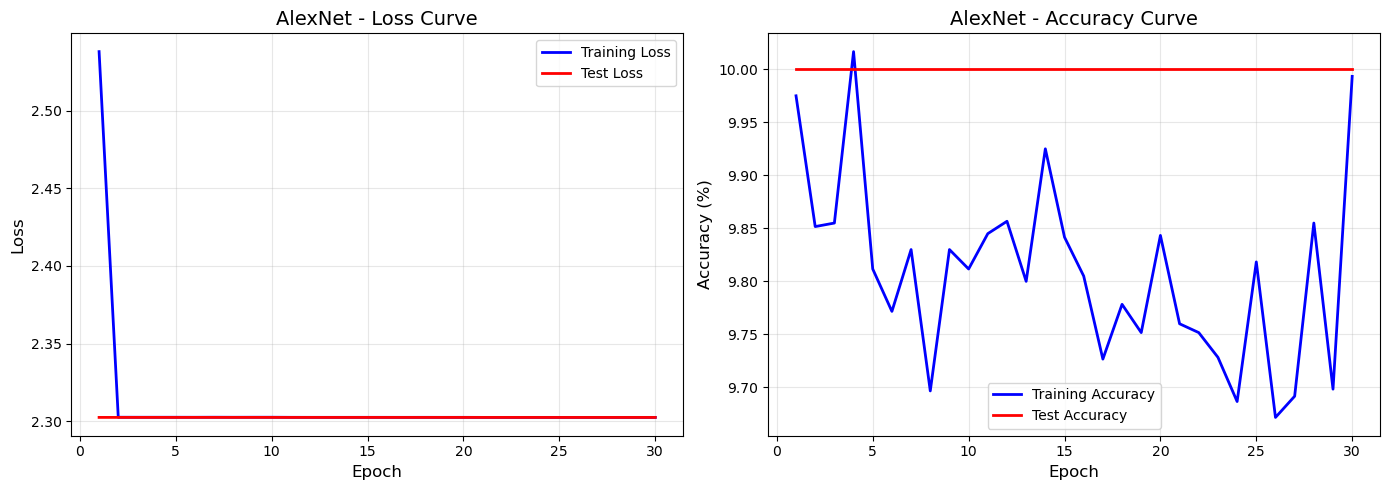

Results saved to alexnet_results.png
Model saved to AlexNet_fashion_mnist.pth


In [2]:
"""
AlexNet for Fashion-MNIST
完整实现2012年ImageNet冠军架构
原论文: "ImageNet Classification with Deep Convolutional Neural Networks" by Krizhevsky et al.

原始AlexNet设计特点:
1. 8层网络(5个卷积层 + 3个全连接层)
2. ReLU激活函数
3. 局部响应归一化(LRN)
4. Overlapping Pooling
5. Dropout正则化
6. 数据增强

由于Fashion-MNIST是28x28的灰度图像，我们需要resize到224x224以适应AlexNet
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class LocalResponseNorm(nn.Module):
    """局部响应归一化 - AlexNet原始设计中的重要组件"""
    def __init__(self, size=5, alpha=1e-4, beta=0.75, k=2.0):
        super(LocalResponseNorm, self).__init__()
        self.lrn = nn.LocalResponseNorm(size, alpha, beta, k)

    def forward(self, x):
        return self.lrn(x)


class AlexNet(nn.Module):
    """
    完整的AlexNet架构

    原始架构 (输入: 224x224x3):
    Conv1: 96 filters, 11x11, stride 4 -> 55x55x96
    LRN + MaxPool: 3x3, stride 2 -> 27x27x96
    Conv2: 256 filters, 5x5, padding 2 -> 27x27x256
    LRN + MaxPool: 3x3, stride 2 -> 13x13x256
    Conv3: 384 filters, 3x3, padding 1 -> 13x13x384
    Conv4: 384 filters, 3x3, padding 1 -> 13x13x384
    Conv5: 256 filters, 3x3, padding 1 -> 13x13x256
    MaxPool: 3x3, stride 2 -> 6x6x256
    FC1: 6*6*256 = 9216 -> 4096
    FC2: 4096 -> 4096
    FC3: 4096 -> num_classes

    由于Fashion-MNIST是单通道灰度图，第一层输入通道改为1
    """
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # 特征提取层
        self.features = nn.Sequential(
            # Conv1: 输入 224x224x1 -> 输出 55x55x96
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 27x27x96

            # Conv2: 27x27x96 -> 27x27x256
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 13x13x256

            # Conv3: 13x13x256 -> 13x13x384
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv4: 13x13x384 -> 13x13x384
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv5: 13x13x384 -> 13x13x256
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 6x6x256
        )

        # 自适应池化确保固定输出尺寸
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # 分类器
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        self._initialize_weights()

    def _initialize_weights(self):
        """
        AlexNet原始权重初始化:
        - Conv层: 均值0，标准差0.01的高斯分布
        - Conv2, Conv4, Conv5的bias初始化为1
        - 其他层bias初始化为0
        - FC层: 均值0，标准差0.01的高斯分布
        """
        for i, m in enumerate(self.modules()):
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                nn.init.constant_(m.bias, 0)

        # Conv2, Conv4, Conv5的bias设为1
        # 在原始AlexNet中，这样做是为了给ReLU提供正的输入
        self.features[4].bias.data.fill_(1)   # Conv2
        self.features[10].bias.data.fill_(1)  # Conv4
        self.features[12].bias.data.fill_(1)  # Conv5

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def load_data(batch_size=128):
    """
    加载Fashion-MNIST数据集
    AlexNet需要224x224的输入，所以需要resize
    同时使用数据增强（AlexNet原始论文中的重要技术）
    """
    transform_train = transforms.Compose([
        transforms.Resize(256),                      # 先resize到256
        transforms.RandomCrop(224),                  # 随机裁剪到224（AlexNet数据增强）
        transforms.RandomHorizontalFlip(),           # 水平翻转（AlexNet数据增强）
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),                  # 测试时中心裁剪
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=transform_test
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    return running_loss / len(train_loader), 100. * correct / total


def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return test_loss / len(test_loader), 100. * correct / total


def plot_results(train_losses, train_accs, test_losses, test_accs, model_name='AlexNet'):
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title(f'{model_name} - Loss Curve', fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(epochs, test_accs, 'r-', label='Test Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title(f'{model_name} - Accuracy Curve', fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Results saved to {model_name.lower()}_results.png")


def main():
    batch_size = 128
    learning_rate = 0.001
    num_epochs = 30

    print("Loading Fashion-MNIST dataset...")
    train_loader, test_loader = load_data(batch_size)
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")

    model = AlexNet(num_classes=10).to(device)

    print(f"\nModel Architecture:\n{model}")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    print("\nStarting training...")
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)

        scheduler.step()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch [{epoch:2d}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best Test Accuracy: {max(test_accs):.2f}%")

    plot_results(train_losses, train_accs, test_losses, test_accs, 'AlexNet')

    torch.save(model.state_dict(), 'AlexNet_fashion_mnist.pth')
    print("Model saved to AlexNet_fashion_mnist.pth")


if __name__ == '__main__':
    main()